In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import imageio
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = './Kvasir-SEG/'
image_path = os.path.join(data_dir, 'preprocessed_images/')
mask_path = os.path.join(data_dir, 'preprocessed_masks/')
image_names = os.listdir(image_path)
image_list = [image_path+i for i in image_names]
mask_list = [mask_path+i for i in image_names]

In [3]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [4]:
def load_images(image_path, mask_path):
    """
    Load image and mask pair
    
    Arguments:
        image_path -- Path to the image
        mask -- Path to the corresponding mask
    Returns: 
        img, mask -- Image tensor and mask tensor
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    return img, mask

In [6]:
image_ds = dataset.map(load_images)
train_data, test_data = tf.keras.utils.split_dataset(image_ds, left_size=0.9, shuffle=True, seed=100)

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, 
                  3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    bnorm = BatchNormalization()(conv)
    conv = Conv2D(n_filters, 
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(bnorm)
    bnorm = BatchNormalization()(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(bnorm)
         
    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(n_filters, 
                         3,    
                         strides=2,
                         padding='same')(expansive_input)
    
    concat = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(concat)
    conv = Conv2D(n_filters,   
                  3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    return conv

In [10]:
def unet_model(input_size=(256, 256, 3), n_filters=32):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- Resulting U-Net model
    """
    inputs = Input(input_size)

    cblock1 = conv_block(inputs=inputs,     n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2, dropout_prob=0.3)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4, dropout_prob=0.3)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3) 

    bottleneck = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)

    ublock1 = upsampling_block(bottleneck[0], cblock4[1], n_filters*8)
    ublock2 = upsampling_block(ublock1,       cblock3[1], n_filters*4)
    ublock3 = upsampling_block(ublock2,       cblock2[1], n_filters*2)
    ublock4 = upsampling_block(ublock3,       cblock1[1], n_filters*1)

    out = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock4)

    out = Conv2D(2, 
                 1, 
                 padding='same',
                 activation='sigmoid')(out)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [11]:
unet = unet_model(n_filters=16)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['batch_normalization[0][0

In [12]:
unet.compile(optimizer='adam',
            loss=tf.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

In [13]:
EPOCHS = 20
BUFFER_SIZE = 640
BATCH_SIZE = 32
train_partition = train_data.cache().shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
model_history = unet.fit(train_partition, epochs=EPOCHS)

Epoch 1/20
29/29 [==============================] - 510s 17s/step - loss: 0.3807 - accuracy: 0.8151
Epoch 2/20
29/29 [==============================] - 435s 15s/step - loss: 0.2873 - accuracy: 0.8641
Epoch 3/20
29/29 [==============================] - 462s 16s/step - loss: 0.2693 - accuracy: 0.8717
Epoch 4/20
29/29 [==============================] - 446s 15s/step - loss: 0.2562 - accuracy: 0.8821
Epoch 5/20
29/29 [==============================] - 384s 13s/step - loss: 0.2423 - accuracy: 0.8918
Epoch 6/20
29/29 [==============================] - 408s 14s/step - loss: 0.2320 - accuracy: 0.8998
Epoch 7/20
29/29 [==============================] - 462s 16s/step - loss: 0.2136 - accuracy: 0.9070
Epoch 8/20
29/29 [==============================] - 393s 14s/step - loss: 0.2085 - accuracy: 0.9116
Epoch 9/20
29/29 [==============================] - 417s 14s/step - loss: 0.1953 - accuracy: 0.9175
Epoch 10/20
29/29 [==============================] - 378s 13s/step - loss: 0.1861 - accuracy: 0.9204

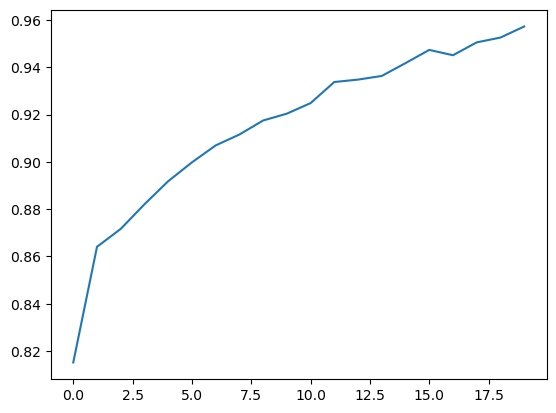

In [14]:
plt.plot(model_history.history["accuracy"])

In [15]:
unet.evaluate(test_data.batch(100))

1/1 [==============================] - 10s 10s/step - loss: 0.2738 - accuracy: 0.9026


[0.27379122376441956, 0.9025880694389343]

In [79]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_results(display_list, titles):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

900
1/1 [==============================] - 0s 211ms/step


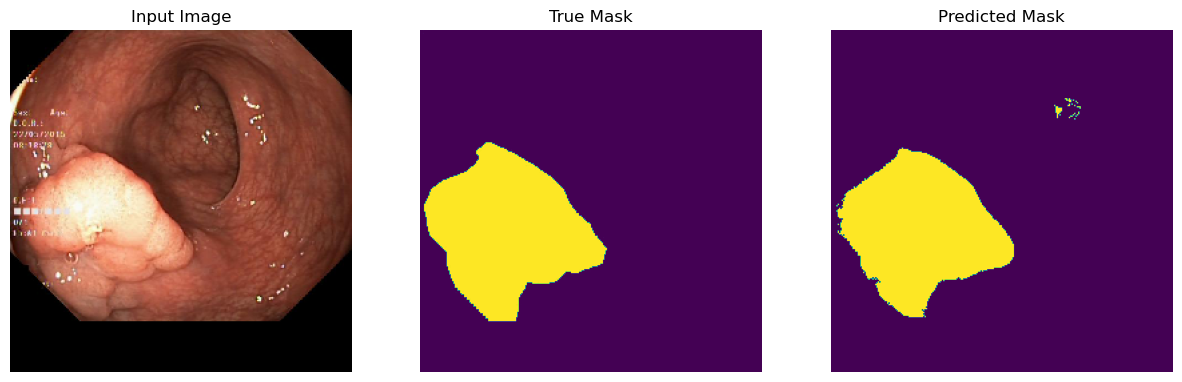

900
1/1 [==============================] - 0s 218ms/step


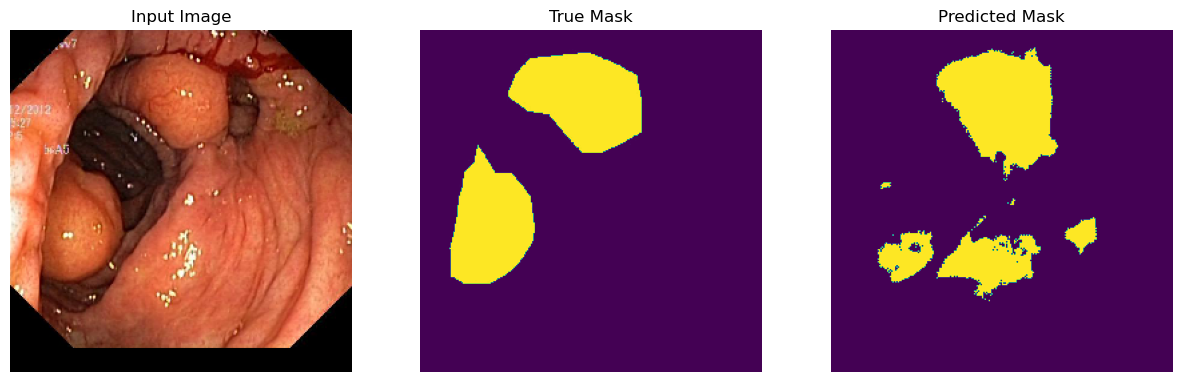

900
1/1 [==============================] - 0s 186ms/step


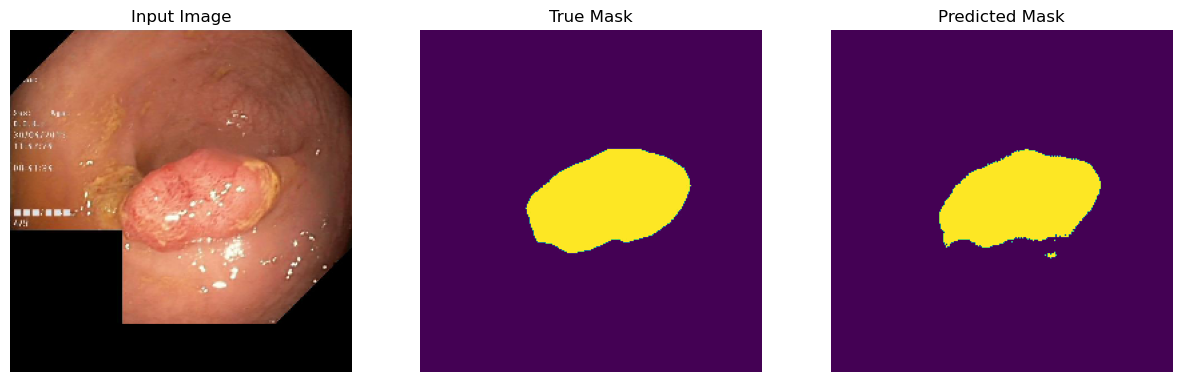

900
1/1 [==============================] - 0s 169ms/step


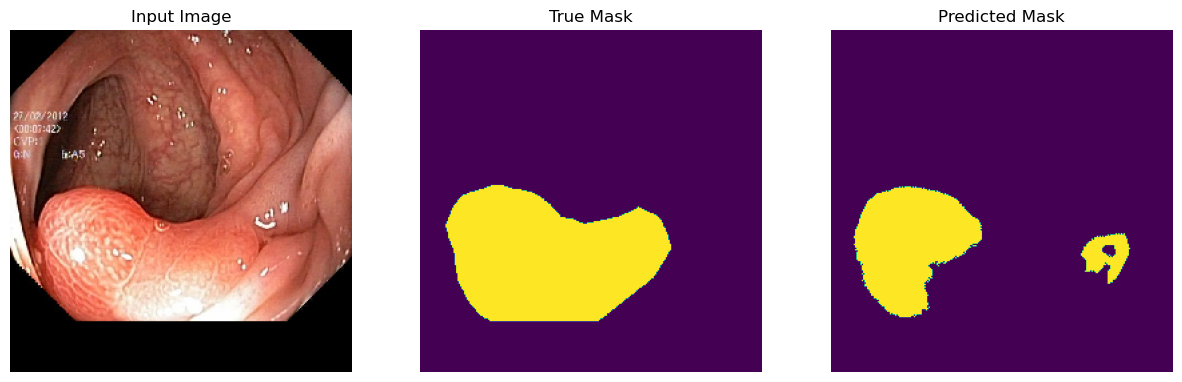

900
1/1 [==============================] - 0s 150ms/step


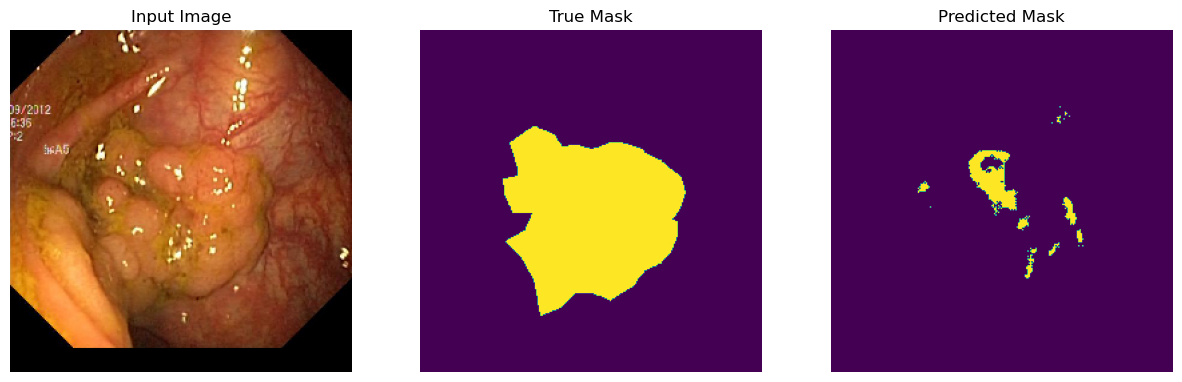

900
1/1 [==============================] - 0s 238ms/step


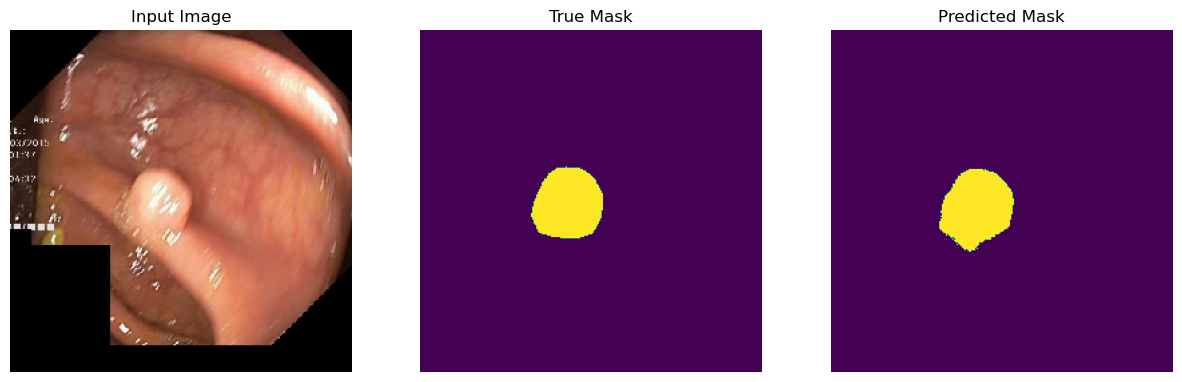

900
1/1 [==============================] - 0s 215ms/step


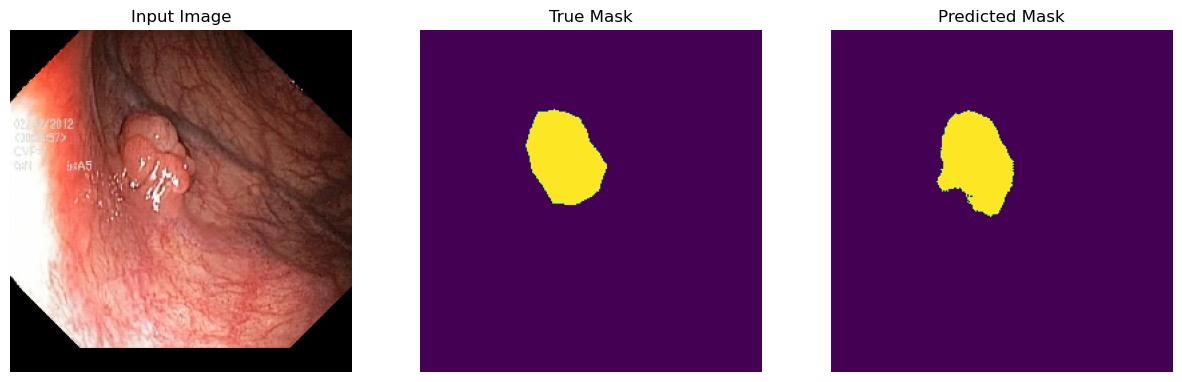

900
1/1 [==============================] - 0s 260ms/step


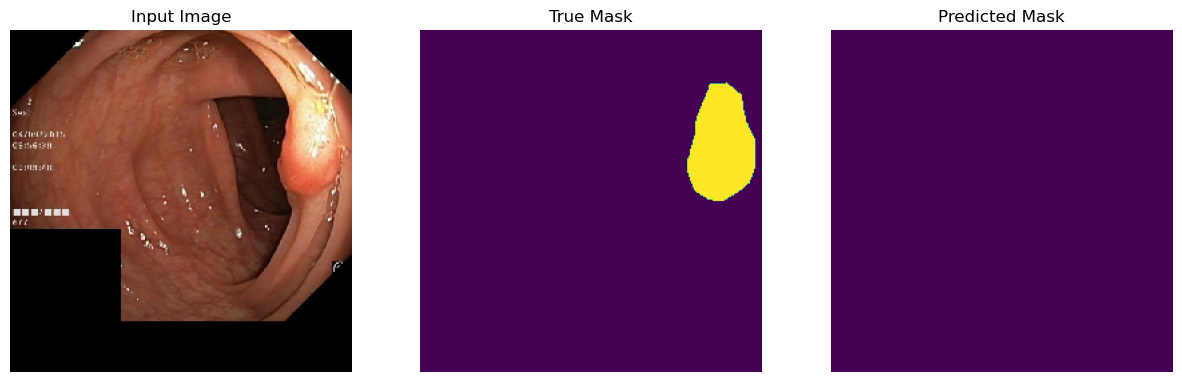

900
1/1 [==============================] - 0s 131ms/step


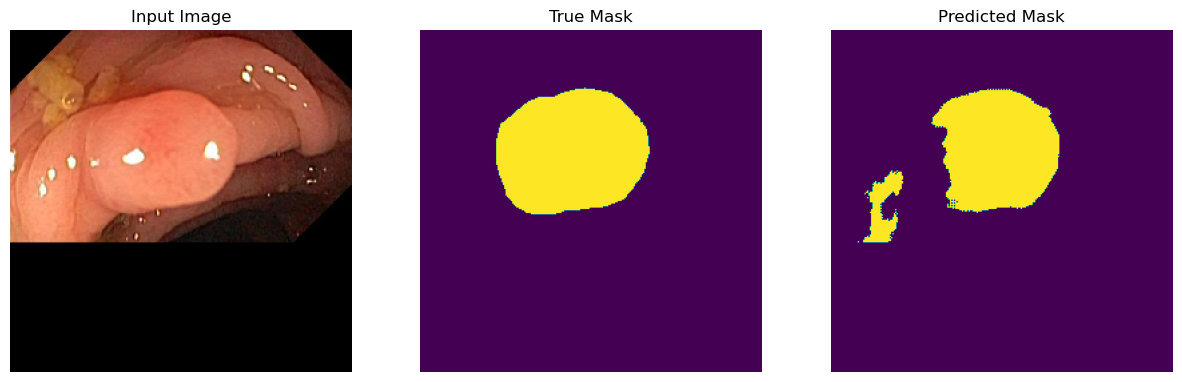

900
1/1 [==============================] - 0s 120ms/step


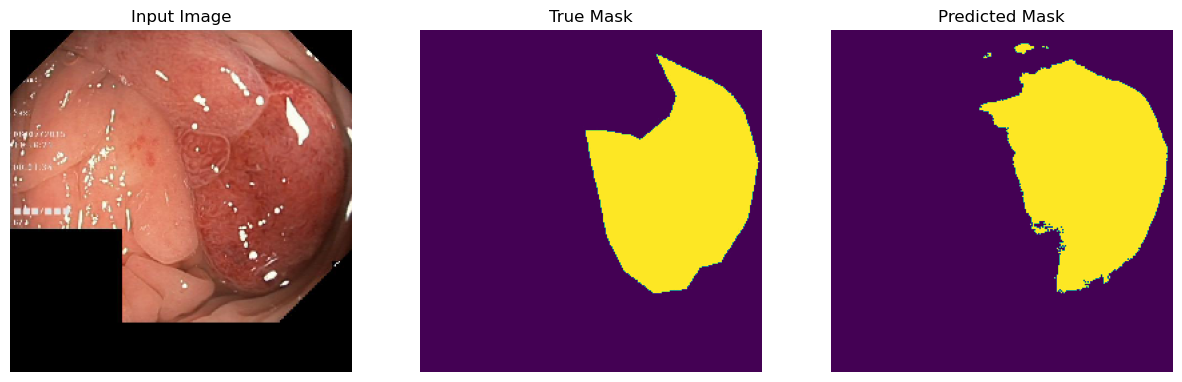

In [80]:
for image, mask in test_data.take(10):
    count = 0
    for test, _ in train_data:
        count += 1
        if np.linalg.norm(image - test) < 0.01:
            raise Exception("I have seen this one")
    print(count)
    image = tf.expand_dims(image, axis=0)
    pred_mask = unet.predict(image)
    show_results([image[0], mask, create_mask(pred_mask)], ['Input Image', 'True Mask', 'Predicted Mask'])

In [84]:
unet.save('unet.keras')

In [21]:
from utils import load_and_pad

In [85]:
img, _ = load_and_pad('Test/Polyp1.jpg')
img = tf.image.resize(img, (256, 256), method='nearest')
img = tf.expand_dims(img, axis=0) / 255
img.numpy().max()

1.0

1/1 [==============================] - 0s 133ms/step


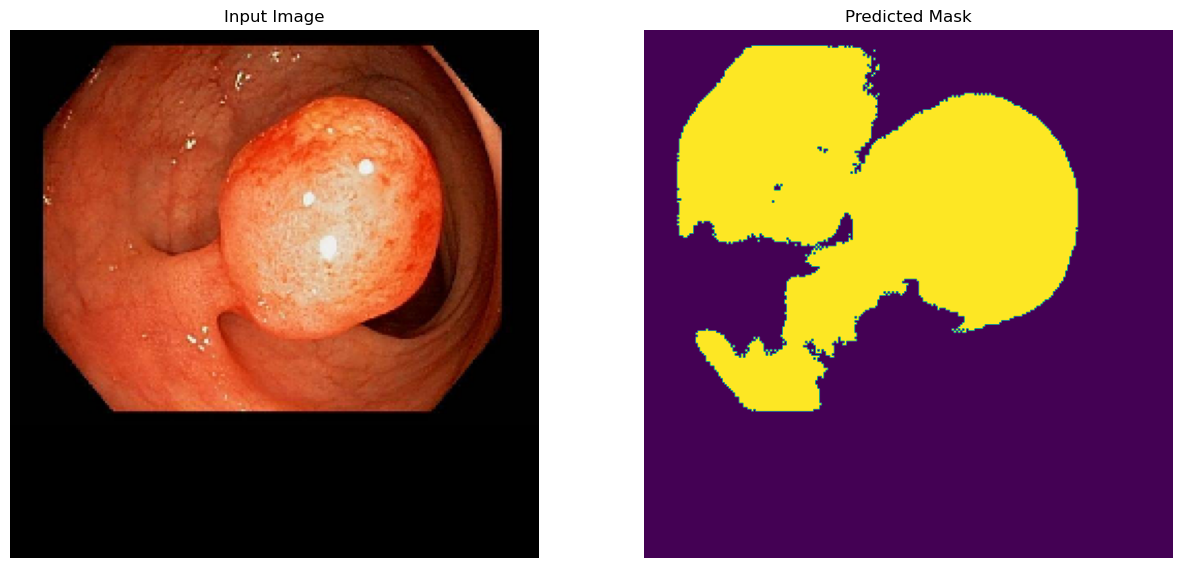

In [81]:
pred_mask = unet.predict(img)
show_results([img[0], create_mask(pred_mask)], ["Input Image", "Predicted Mask"])